### PLACE ALL IMPORTS HERE (easier to keep track of)

In [225]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

**NOTE: All of this functionality is now located in the loadCharFeatures module**

In [255]:
import loadCharFeatures
(characters, character_namelists, total_features, top_n) = loadCharFeatures.getCharVectorsFromJson()

Most common words in book:  [('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so

**Create texts to feed to gensim, print out BOW for each character**

In [260]:
texts = [None for key in characters]
names = {}
i = 0
for key, value in characters.iteritems():
    print str(key) + ": " + str(value)
    texts[i] = value
    names[key] = i
    i += 1
    print
print len(characters)

Madam Rosmerta: [u'forc_PATIENT', u'gasp_PATIENT', u'breath_PATIENT', u'stare_AGENT', u'fill_AGENT', u'eject_wizard_AGENT', u'totter_AGENT', u'send_bottl_AGENT', u'have_oth_AGENT', u'tip_you_AGENT', u'help__AGENT', u'admit_AGENT', u'let_sigh_AGENT', u'abl_MOD', u'stay_SAY', u'black_SAY', u'area_SAY', u'minist_SAY', u'dementor_SAY', u'search_SAY', u'whole_SAY', u'villag_SAY', u'twjce_SAY', u'worst_SAY', u'wors_SAY', u'murder_SAY', u'poor_SAY', u'mean_SAY', u'natur_SAY', u'black_SAY', u'leagu_SAY', u'doe_SAY', u'work_SAY', u'black_SAY', u'potter_SAY', u'secret-keep_SAY', u'suspect_SAY', u'black_SAY', u'black_SAY', u'betray_SAY', u'manag_SAY', u'disappear_SAY', u'ministri_SAY', u'magic_SAY', u'caught_SAY', u'next_SAY', u'day_SAY', u'pettigrew_SAY', u'fat_SAY', u'boy_SAY', u'alway_SAY', u'tag_SAY', u'hogwart_SAY', u'black_SAY', u'taken_SAY', u'twenti_SAY', u'member_SAY', u'magic_SAY', u'law_SAY', u'enforc_SAY', u'squad_SAY', u'pettigrew_SAY', u'receiv_SAY', u'order_SAY', u'merlin_SAY', u'c

**Print most common features (to do: maybe filter these out of the model?)**

In [231]:
counter = Counter(total_features)
top_n = counter.most_common(50)
print top_n
print

[(u'oh_SAY', 397.0), (u'yes_SAY', 360.0), (u'stare_AGENT', 334.0), (u'yeah_SAY', 308.0), (u'potter_SAY', 296.0), (u'shoulder_POSS', 269.0), (u'good_SAY', 268.0), (u'stood_AGENT', 257.0), (u'tell__AGENT', 257.0), (u'walk_AGENT', 255.0), (u'sat_AGENT', 250.0), (u'whi_SAY', 249.0), (u'robe_POSS', 245.0), (u'hair_POSS', 219.0), (u'mean_SAY', 218.0), (u'thing_SAY', 211.0), (u'ear_POSS', 210.0), (u'mind_POSS', 205.0), (u'cours_SAY', 205.0), (u'doe_SAY', 196.0), (u'move_AGENT', 193.0), (u'need_SAY', 192.0), (u'ad_AGENT', 192.0), (u'year_SAY', 181.0), (u'magic_SAY', 172.0), (u'offic_POSS', 169.0), (u'sure_MOD', 169.0), (u'glanc_AGENT', 169.0), (u'dark_SAY', 165.0), (u'stand_AGENT', 165.0), (u'start_AGENT', 164.0), (u'heart_POSS', 163.0), (u'watch_PATIENT', 163.0), (u'ask__AGENT', 156.0), (u'yeh_SAY', 156.0), (u'sit_AGENT', 156.0), (u'sure_SAY', 155.0), (u'happen_SAY', 153.0), (u'hurri_AGENT', 148.0), (u'mother_POSS', 148.0), (u'bit_SAY', 148.0), (u'pocket_POSS', 146.0), (u'stop_AGENT', 144.0),

## Do LDA Topic Modeling Using Character Features

In [261]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 12

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce good results.

In [233]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [262]:
print(lda.show_topics())

[u'0.007*mind_POSS + 0.006*heart_POSS + 0.005*sure_MOD + 0.005*scar_POSS + 0.005*ear_POSS + 0.005*shoulder_POSS + 0.004*yeah_SAY + 0.004*feel_AGENT + 0.004*stare_AGENT + 0.004*wonder_AGENT', u'0.005*mother_POSS + 0.004*gang_POSS + 0.003*tongu_POSS + 0.002*thing_SAY + 0.002*father_POSS + 0.002*hit_PATIENT + 0.002*parent_POSS + 0.002*hair_POSS + 0.001*friend_POSS + 0.001*stick_POSS', u'0.005*yes_SAY + 0.004*stare_AGENT + 0.004*oh_SAY + 0.004*good_SAY + 0.003*tell__AGENT + 0.003*yeah_SAY + 0.003*hair_POSS + 0.003*ad_AGENT + 0.002*need_SAY + 0.002*sure_SAY', u'0.009*potter_SAY + 0.008*dobbi_SAY + 0.008*sir_SAY + 0.005*squeak_PATIENT + 0.003*doe_SAY + 0.002*set_PATIENT + 0.002*grave_POSS + 0.002*winki_SAY + 0.002*boy_SAY + 0.002*albus_SAY', u'0.002*shriek_AGENT + 0.002*bustl_AGENT + 0.002*abl_MOD + 0.002*offic_POSS + 0.001*talk_SAY + 0.001*tell__AGENT + 0.001*point_AGENT + 0.001*take_quaffl_AGENT + 0.001*sister_MOD + 0.001*pat__AGENT', u'0.013*hollow_POSS + 0.003*robe_POSS + 0.003*grandmoth

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
mind_POSS heart_POSS sure_MOD scar_POSS ear_POSS shoulder_POSS yeah_SAY feel_AGENT stare_AGENT wonder_AGENT stood_AGENT realiz_AGENT robe_POSS walk_AGENT found_AGENT glanc_AGENT stomach_POSS sat_AGENT notic_AGENT forehead_POSS ask__AGENT whi_SAY life_POSS potter_SAY knee_POSS er_SAY move_AGENT watch_PATIENT hear_AGENT rememb_AGENT 


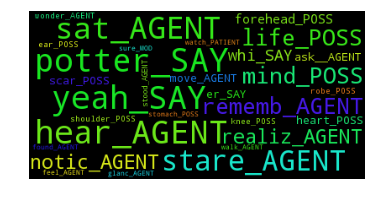

Topic  1
master_SAY kreacher_SAY yes_SAY ze_SAY sister_POSS ave_SAY regulus_SAY tale_POSS black_SAY croak_PATIENT oh_SAY dark_SAY disappear_AGENT fight_SAY order_SAY lord_SAY pass_AGENT vanish_AGENT call_SAY zis_SAY turban_POSS cage_POSS stand_AGENT thank_SAY work_SAY worri_SAY mean_SAY sure_SAY tell_i_AGENT mudblood_SAY 


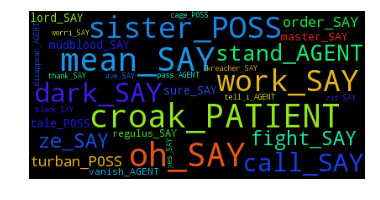

Topic  2
mother_POSS gang_POSS tongu_POSS thing_SAY father_POSS hit_PATIENT parent_POSS hair_POSS friend_POSS stick_POSS snarl_AGENT ask__AGENT life_POSS pull_PATIENT night_SAY help_SAY soul_POSS bag_POSS dad_SAY big_SAY shut_SAY heart_POSS bottom_POSS emerg_AGENT hors_POSS comput_POSS sat_AGENT tell__AGENT backsid_POSS whimper_AGENT 


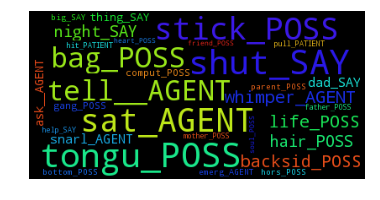

Topic  3
offic_POSS cage_POSS clipboard_POSS yes_SAY potter_SAY hem_SAY desk_POSS sit_AGENT smile_POSS doe_SAY ad_AGENT oh_SAY hair_POSS ministri_SAY sat_AGENT cours_SAY stand_AGENT magic_SAY watch_PATIENT sure_SAY portrait_POSS ought_SAY wing_POSS eyebrow_POSS year_SAY continu_AGENT good_SAY stood_AGENT room_POSS trunk_POSS 


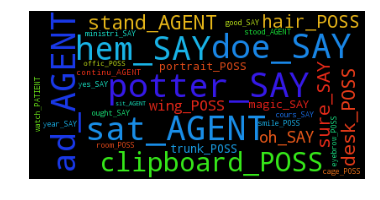

Topic  4
dear_SAY oh_SAY arthur_SAY yes_SAY husband_POSS ad_AGENT son_POSS suppos_SAY good_SAY thing_SAY scoop_POSS call_AGENT bag_POSS cours_SAY father_SAY dark_SAY articl_POSS hair_POSS snap_AGENT handbag_POSS sob_AGENT stood_AGENT lip_POSS worri_SAY follow_PATIENT happen_SAY believ_SAY quill_POSS better_SAY love_SAY 


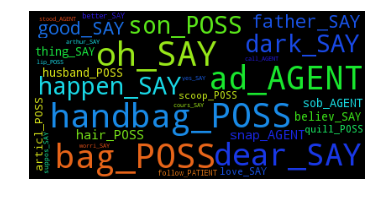

Topic  5
oh_SAY yes_SAY whi_SAY good_SAY mean_SAY doe_SAY stare_AGENT shoulder_POSS yeah_SAY tell__AGENT sat_AGENT bit_SAY hair_POSS ad_AGENT sit_AGENT thing_SAY walk_AGENT bag_POSS anyth_SAY robe_POSS cours_SAY need_SAY snap_AGENT suppos_SAY kept_AGENT dark_SAY start_AGENT stop_SAY talk_SAY ask__AGENT 


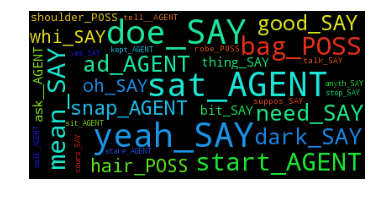

Topic  6
potter_SAY yeh_SAY ter_SAY offic_POSS cabin_POSS yeah_SAY stand_AGENT stood_AGENT desk_POSS say_what_AGENT whi_SAY oh_SAY o_SAY growl_PATIENT robe_POSS fer_SAY stare_AGENT lord_SAY dark_SAY need_SAY cours_SAY good_SAY jus_SAY lip_POSS do_what_AGENT memori_POSS thing_SAY shoulder_POSS move_AGENT growl_AGENT 


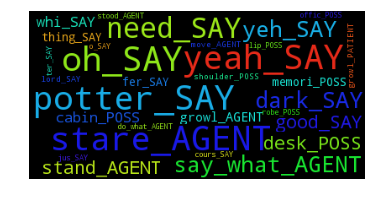

Topic  7
yes_SAY stare_AGENT oh_SAY good_SAY tell__AGENT yeah_SAY hair_POSS ad_AGENT need_SAY sure_SAY cours_SAY stood_AGENT smile_AGENT magic_SAY walk_AGENT sat_AGENT happen_SAY sirius_SAY hogwart_SAY mean_SAY year_SAY ministri_SAY thing_SAY potter_SAY whi_SAY robe_POSS school_SAY find_SAY glass_POSS doe_SAY 


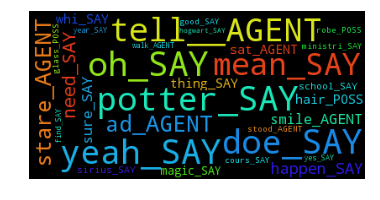

Topic  8
potter_SAY dobbi_SAY sir_SAY squeak_PATIENT doe_SAY set_PATIENT grave_POSS winki_SAY boy_SAY albus_SAY friend_SAY do_it_AGENT shake_head_AGENT call_AGENT squeak_AGENT rasp_PATIENT offic_POSS brother_SAY yes_SAY vanish_AGENT beam_AGENT power_SAY class_POSS sometim_SAY kreacher_SAY regular_SAY hermi_SAY watch_PATIENT cloak_POSS blood_POSS 


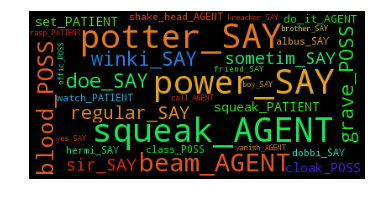

Topic  9
diari_POSS mum_SAY pocket_POSS tell__AGENT year_SAY yeah_SAY watch_PATIENT oh_SAY anyon_SAY dad_SAY bit_SAY perci_SAY give_SAY doe_SAY sat_AGENT laugh_AGENT yes_SAY lot_SAY work_SAY follow_PATIENT good_SAY keep_SAY ear_SAY bet_SAY room_SAY ad_AGENT set_AGENT mother_POSS vanish_AGENT ask__AGENT 


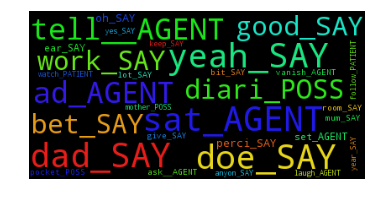

Topic  10
shriek_AGENT bustl_AGENT abl_MOD offic_POSS talk_SAY tell__AGENT point_AGENT take_quaffl_AGENT sister_MOD pat__AGENT answer_POSS resume_strok_AGENT gang_POSS walk_AGENT stun_SAY lead__AGENT recogn_PATIENT six_SAY enough_SAY leav_SAY abl_SAY near_SAY call_SAY potter_SAY good_SAY march_PATIENT yes_SAY lesson_POSS thing_SAY year_SAY 


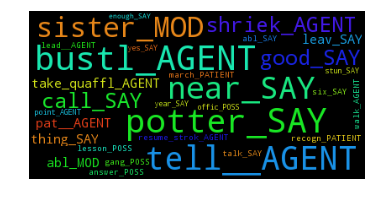

Topic  11
hollow_POSS hollow_POSS robe_POSS grandmoth_POSS pocket_POSS parent_POSS lord_SAY parti_POSS stand_AGENT yes_SAY find_PATIENT oh_SAY return_AGENT chest_POSS pleas_SAY laugh_AGENT walk_AGENT call_AGENT cloak_POSS desk_POSS noth_SAY toad_POSS stare_AGENT hair_POSS sat_AGENT do_what_AGENT move_AGENT kill_PATIENT offic_POSS leav_SAY mother_POSS 


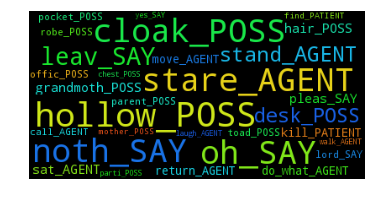

In [263]:
from wordcloud import WordCloud

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for i in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()


#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [264]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

135
0 Madam Rosmerta topic distribution: 
[(1, 0.98854137696491851)]
1 Fang topic distribution: 
[(6, 0.24883248288655674), (7, 0.74460572282302384)]
2 Hogsmeade topic distribution: 
[(6, 0.92361051473850708)]
3 Lupin topic distribution: 
[(7, 0.9990320155021496)]
4 Dudley topic distribution: 
[(2, 0.99830869130206112)]
5 Cho topic distribution: 
[(0, 0.13936019500498872), (5, 0.25645604871364486), (7, 0.28305994255342015), (11, 0.3177567537721917)]
6 Roger Davies topic distribution: 
[(6, 0.97042950862998767)]
7 Dolohov topic distribution: 
[(0, 0.6397709675300578), (3, 0.32936410081906581)]
8 Madam Hooch topic distribution: 
[(6, 0.99003603466341006)]
9 Nicolas Flamel topic distribution: 
[(11, 0.96474297553646515)]
10 Lavender Brown topic distribution: 
[(3, 0.98166641461022974)]
11 Bertha Jorkins topic distribution: 
[(7, 0.98631811285962212)]
12 Fred topic distribution: 
[(9, 0.99918444281798879)]
13 Montague topic distribution: 
[(5, 0.94270644916465118)]
14 Marietta topic distri

#### Bar plot visualization of above character topic probabilities

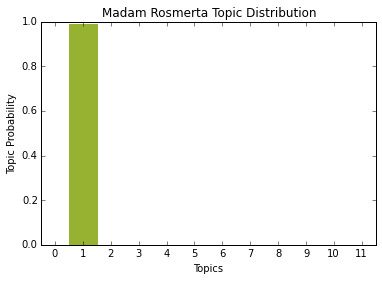

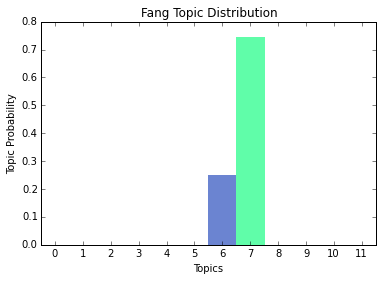

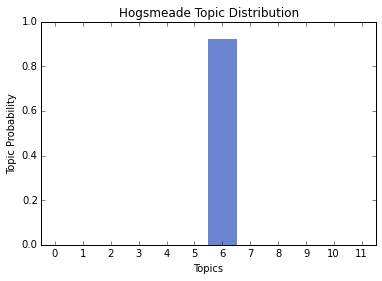

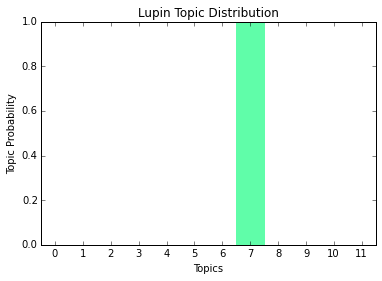

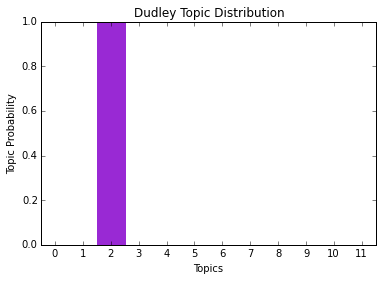

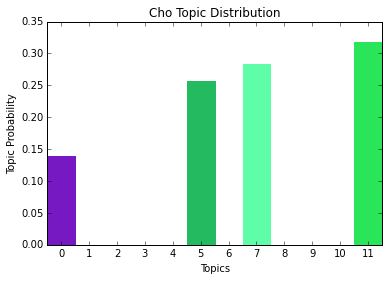

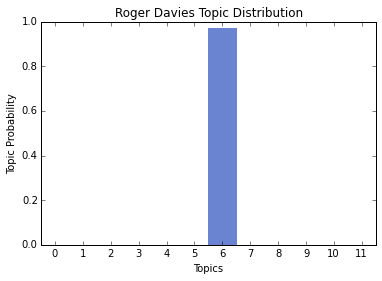

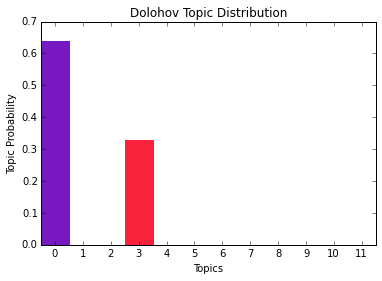

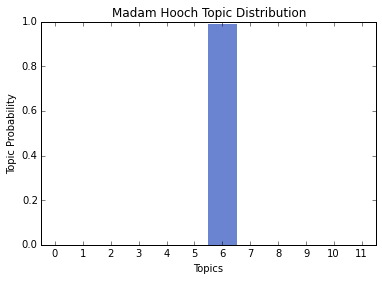

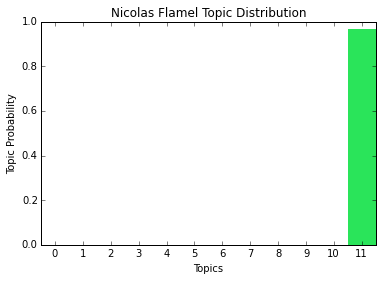

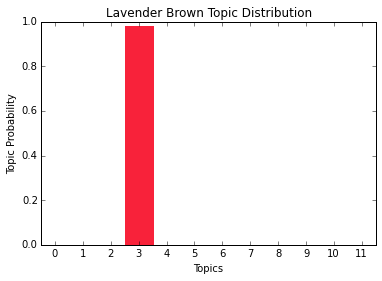

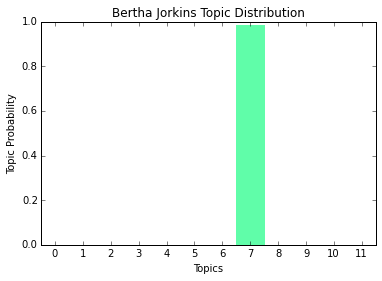

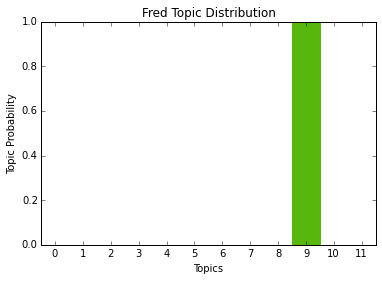

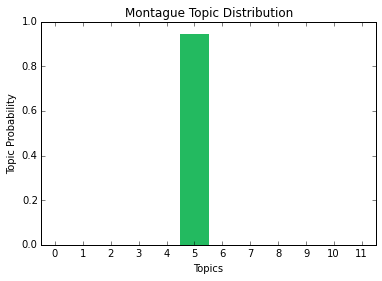

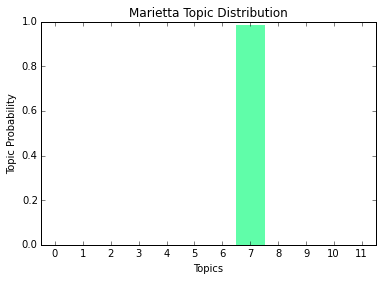

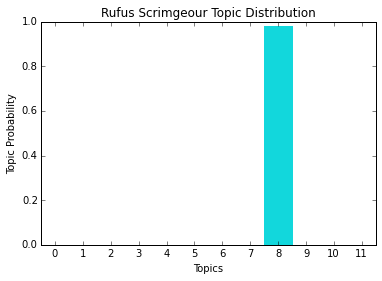

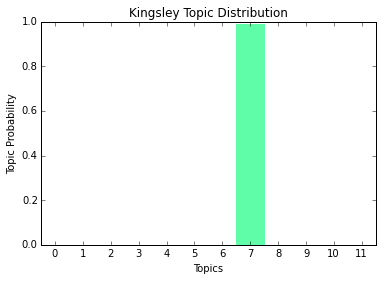

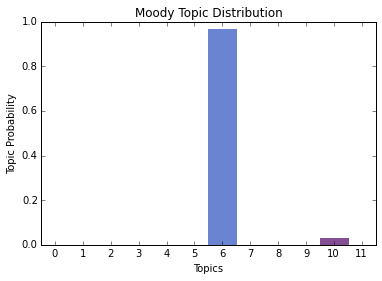

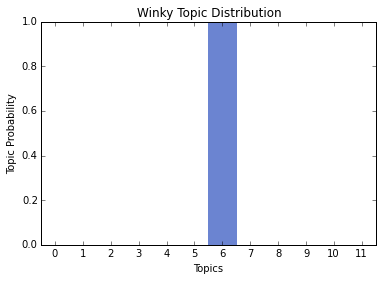

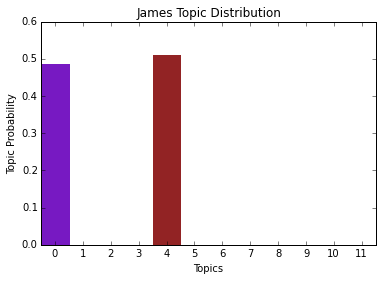

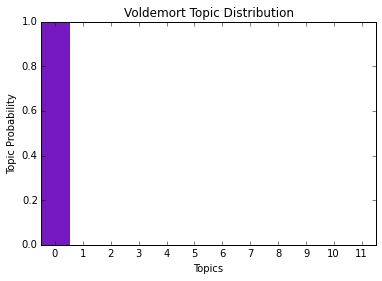

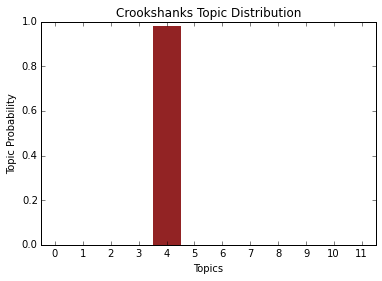

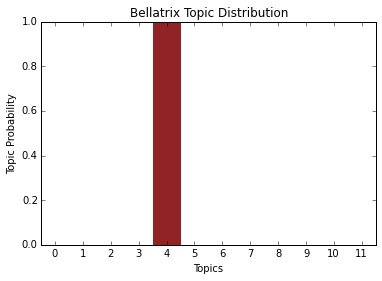

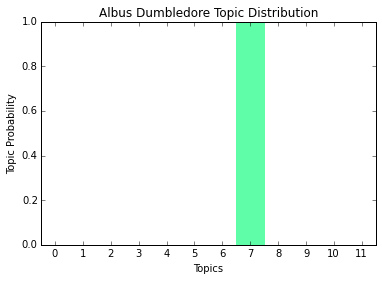

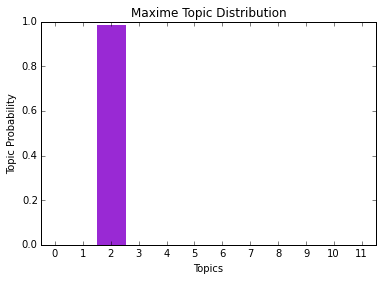

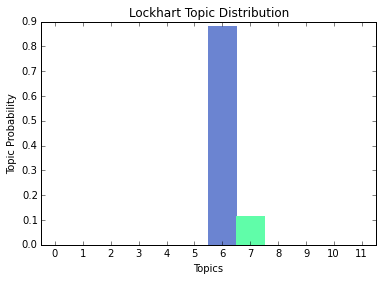

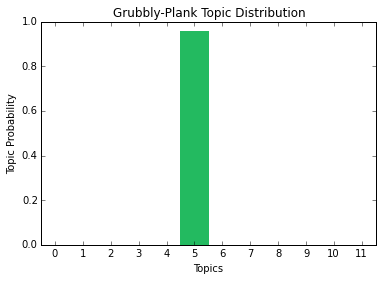

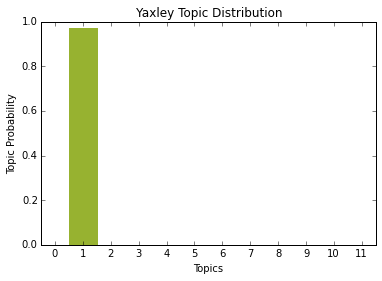

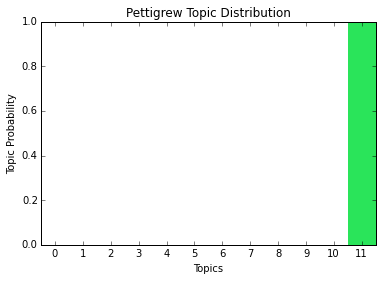

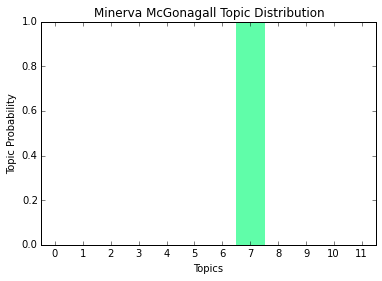

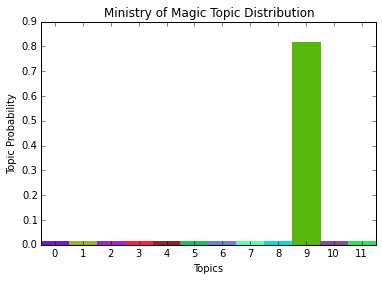

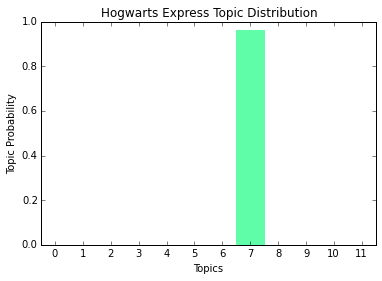

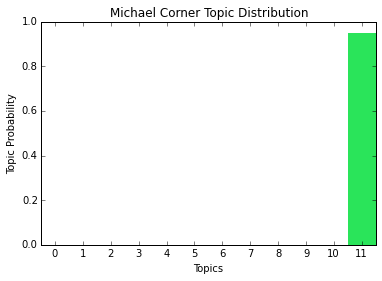

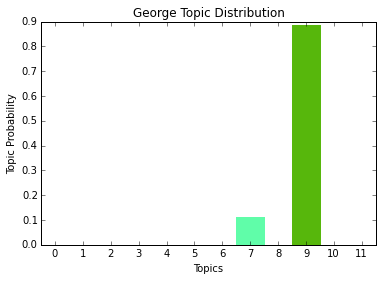

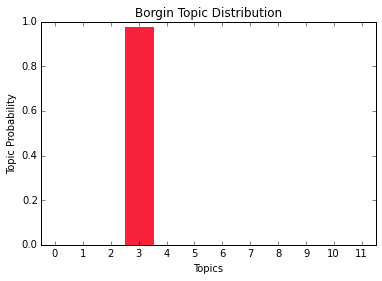

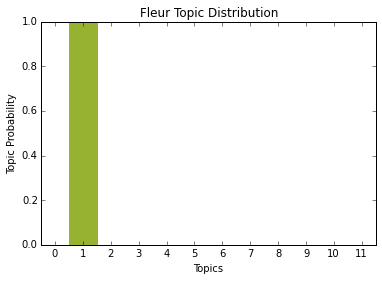

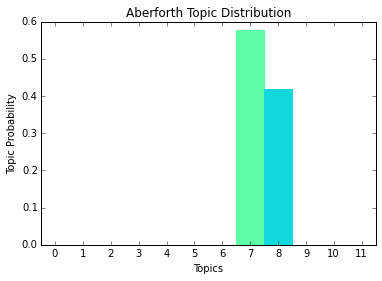

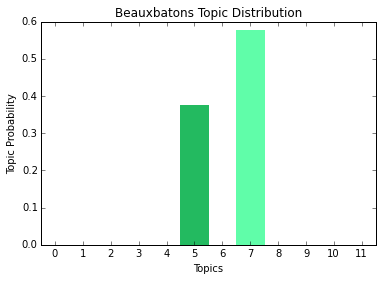

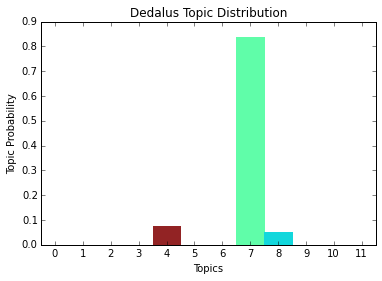

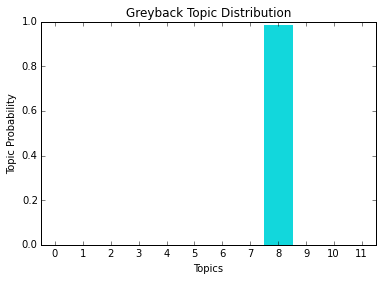

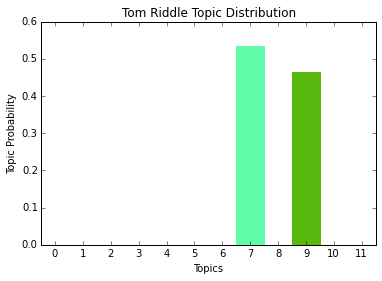

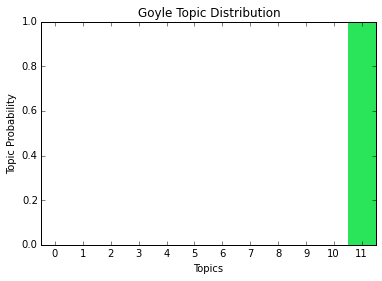

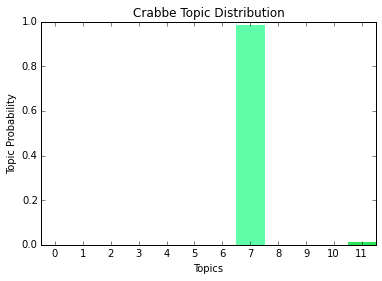

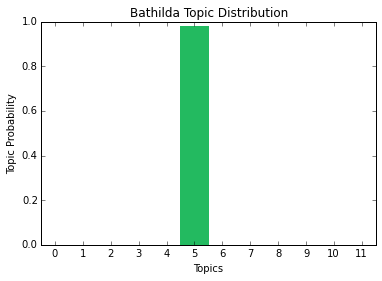

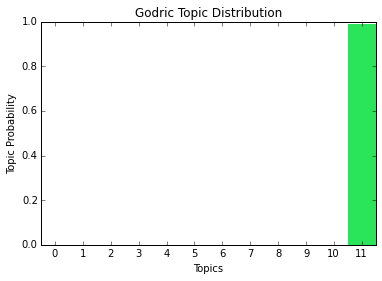

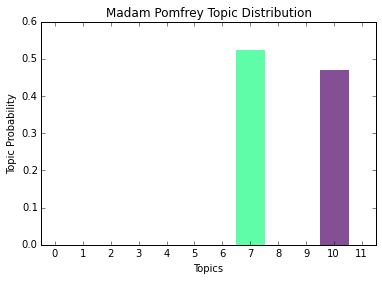

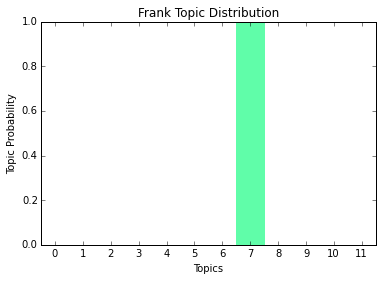

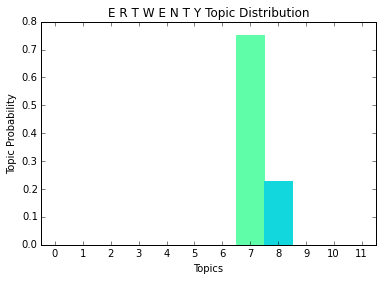

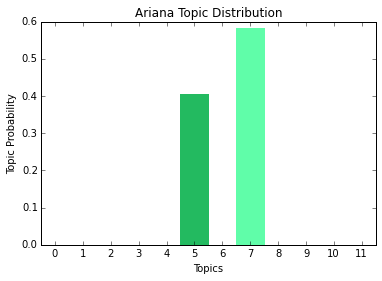

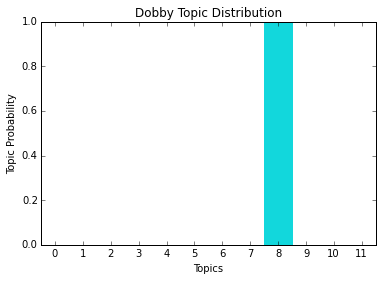

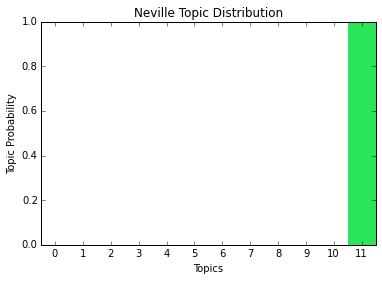

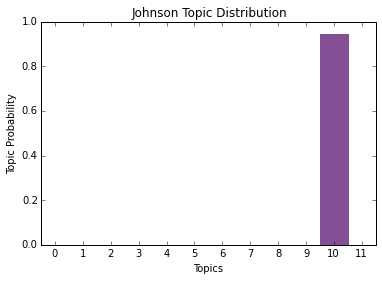

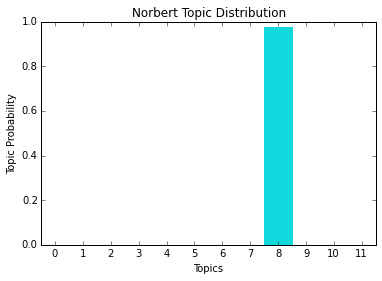

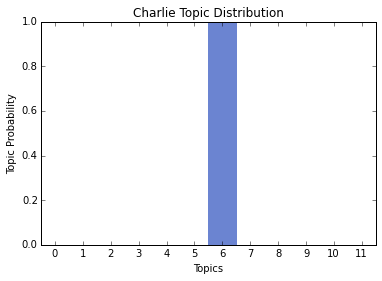

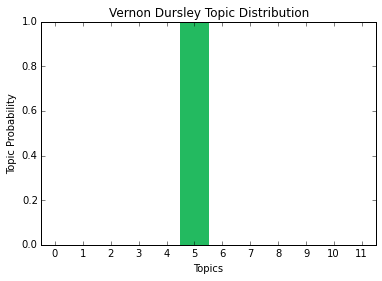

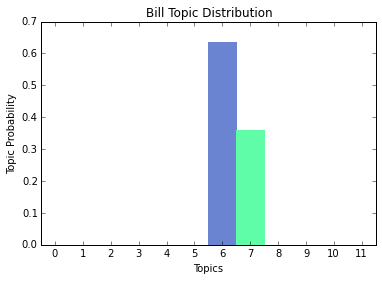

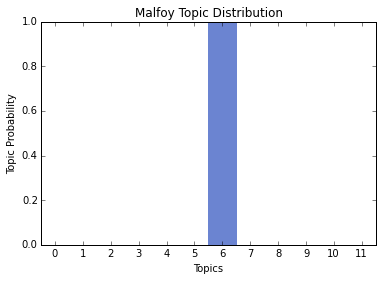

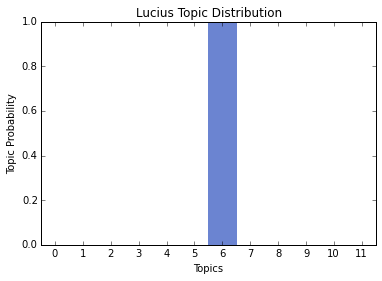

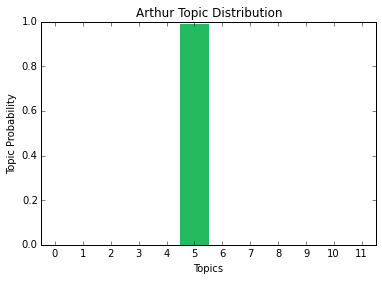

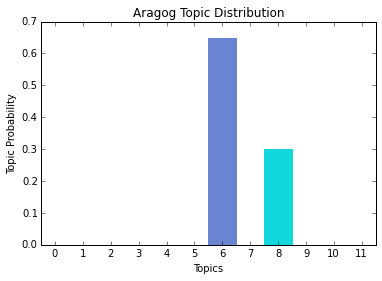

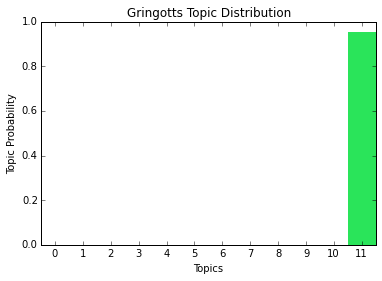

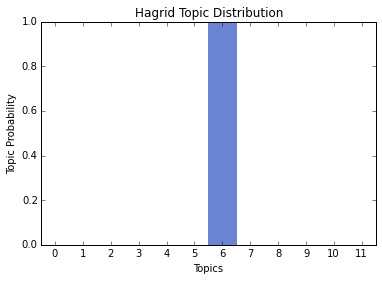

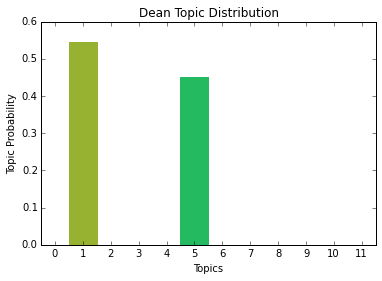

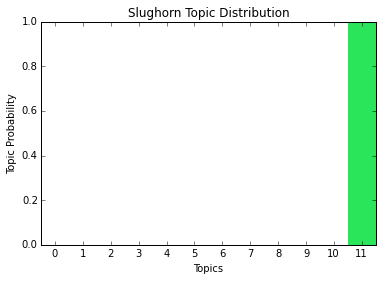

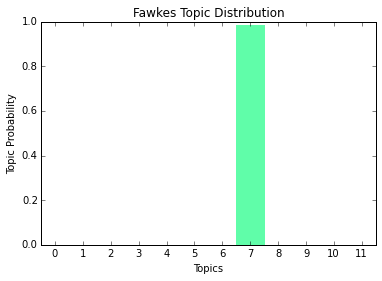

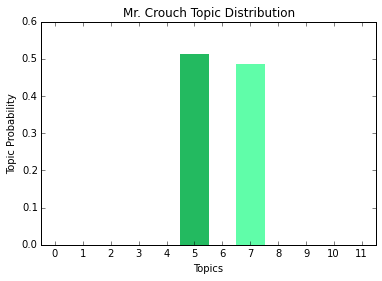

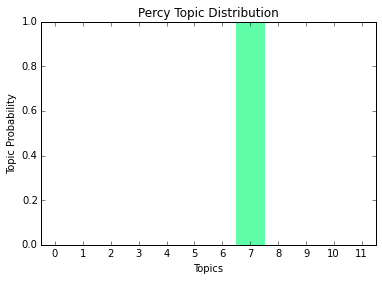

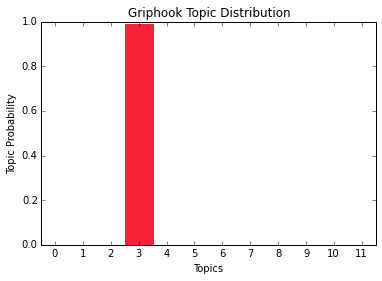

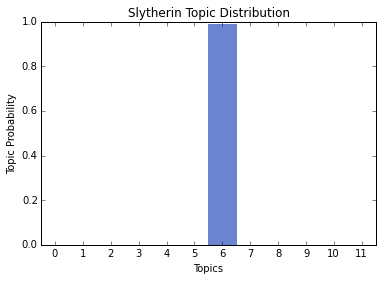

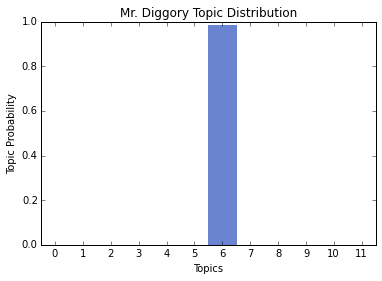

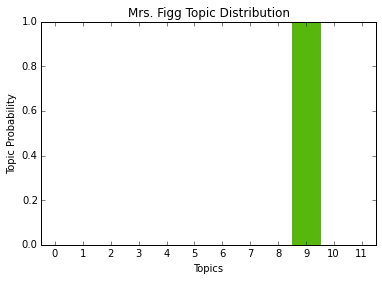

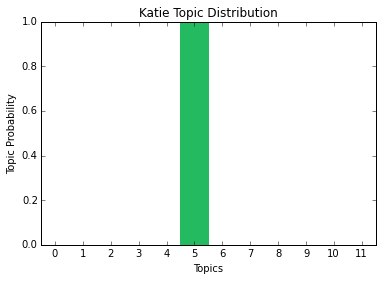

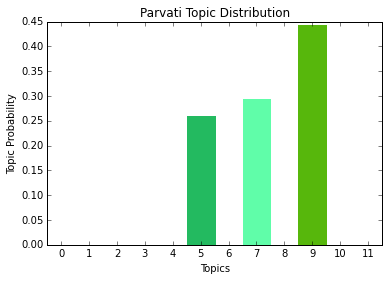

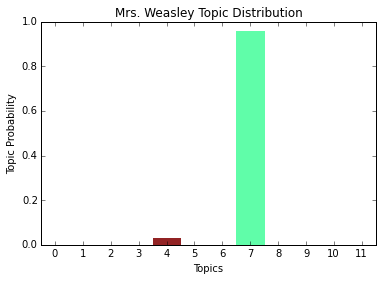

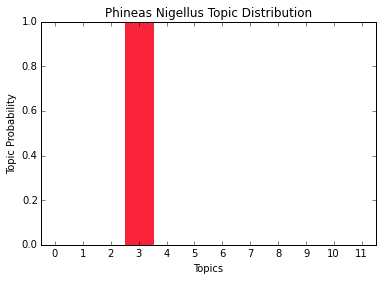

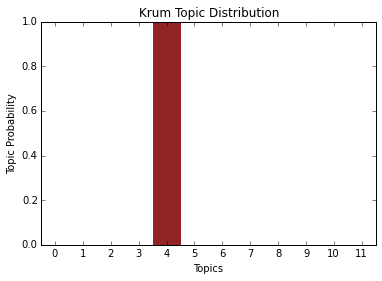

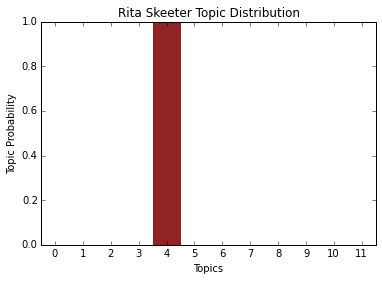

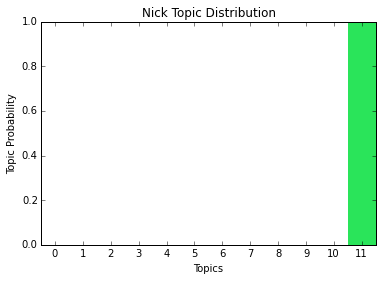

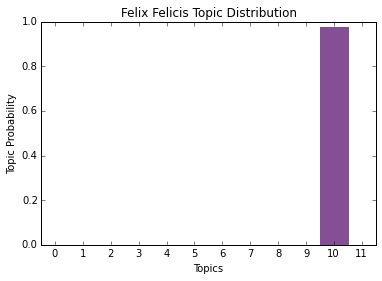

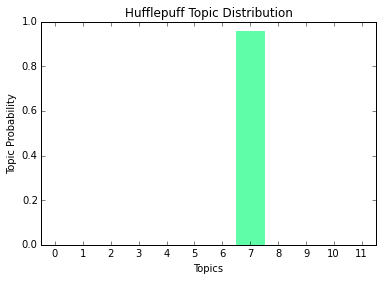

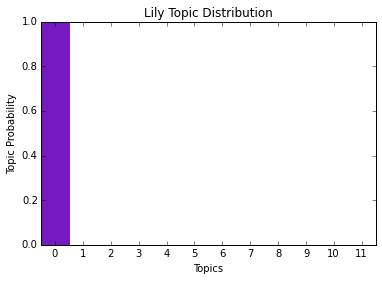

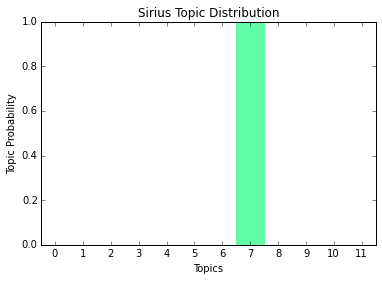

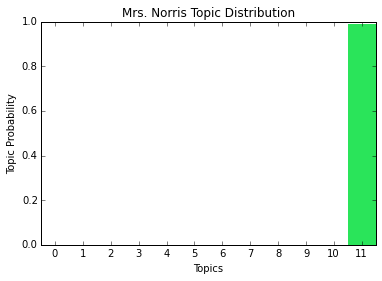

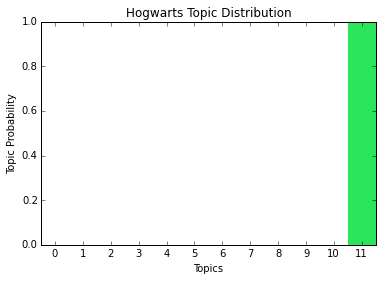

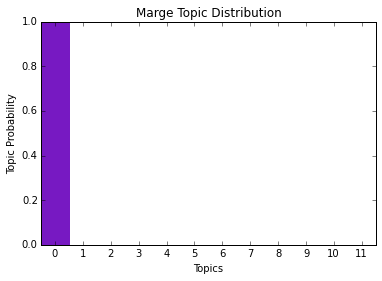

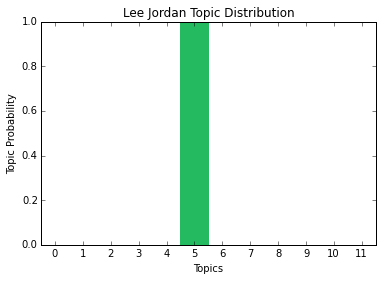

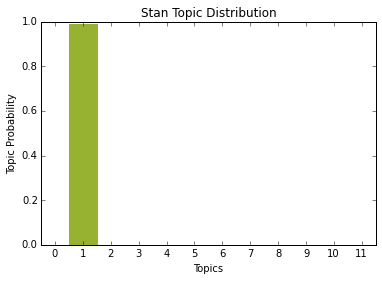

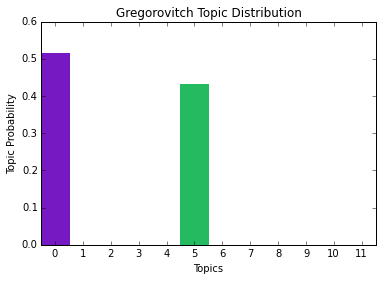

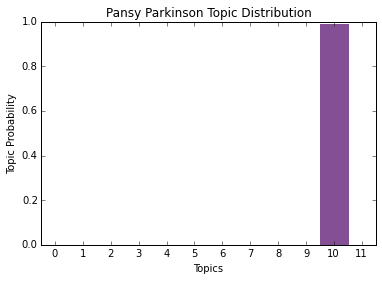

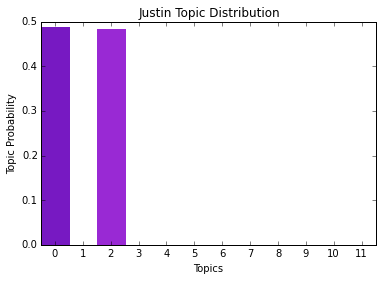

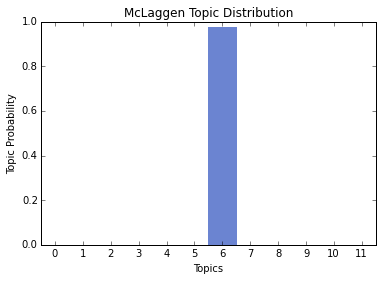

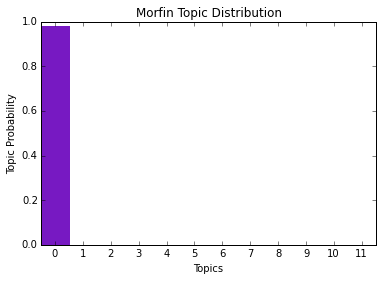

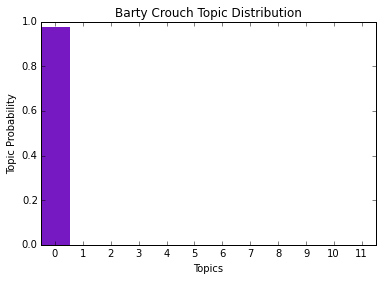

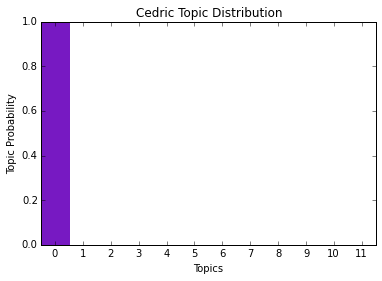

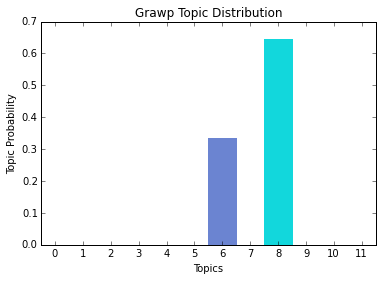

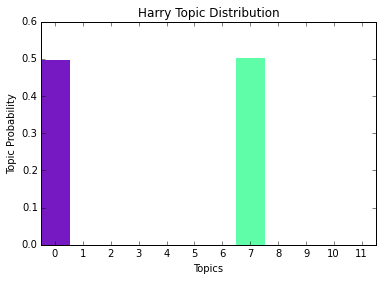

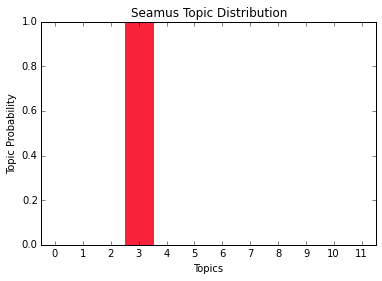

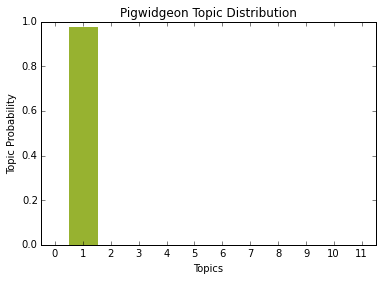

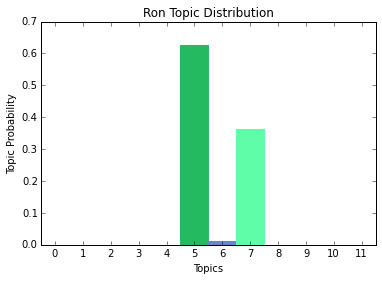

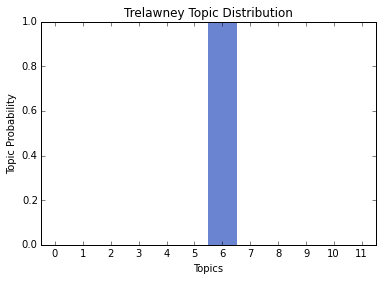

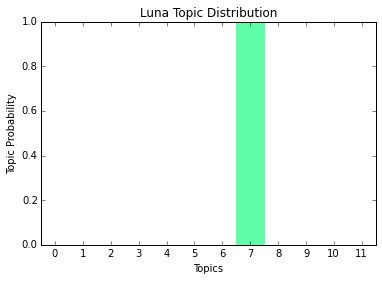

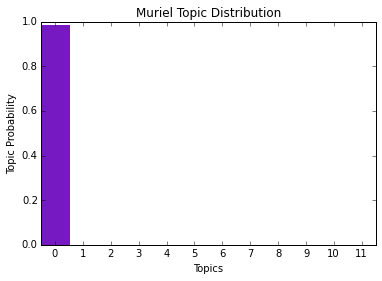

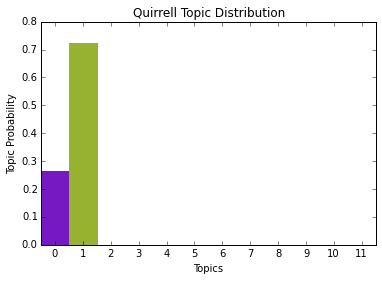

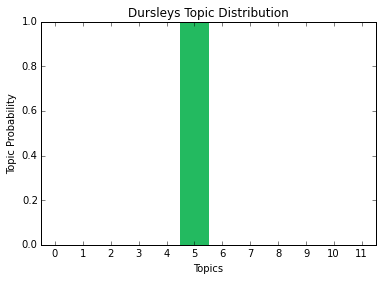

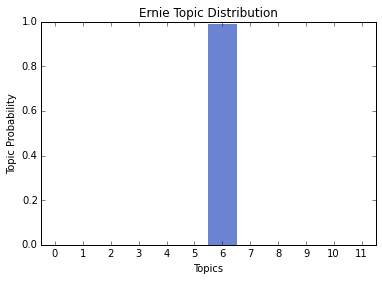

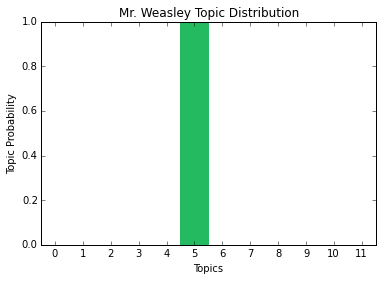

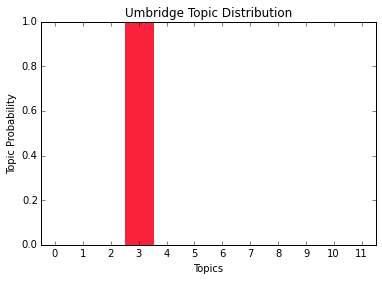

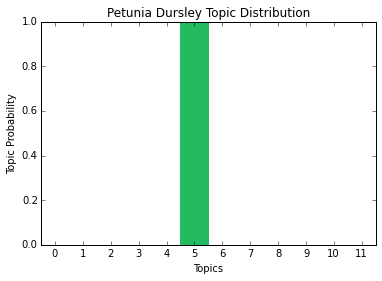

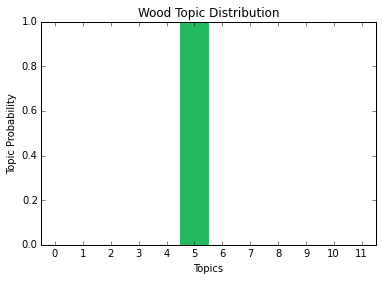

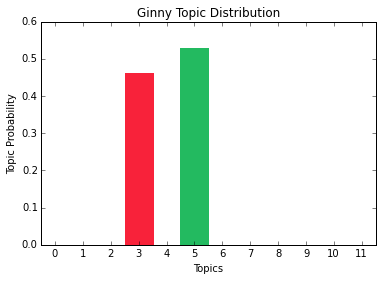

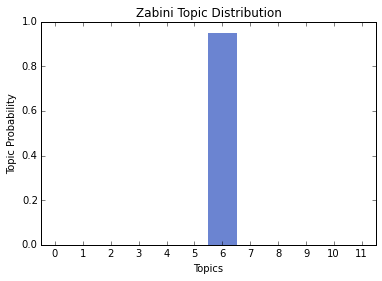

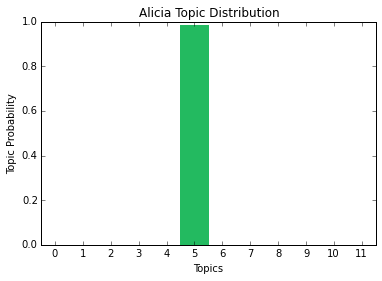

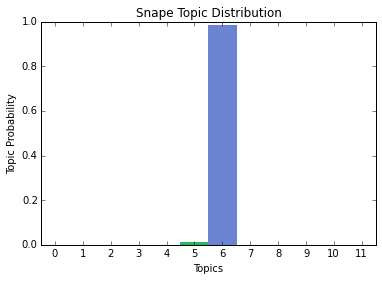

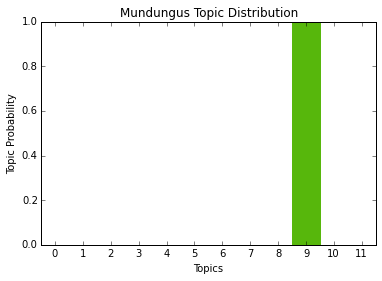

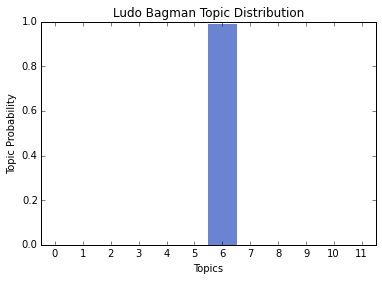

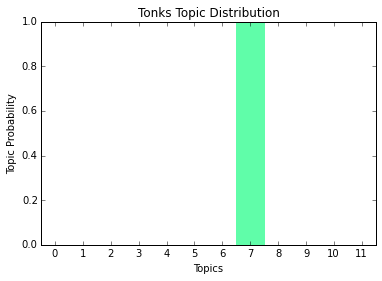

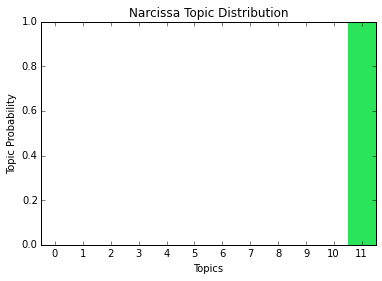

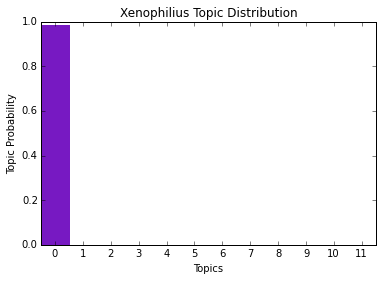

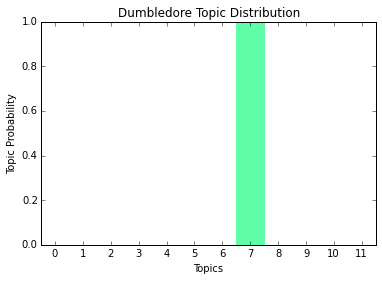

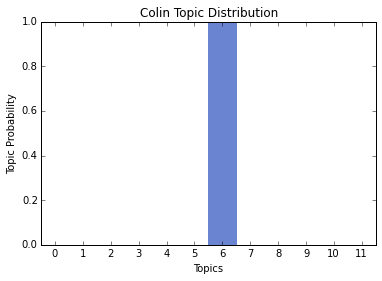

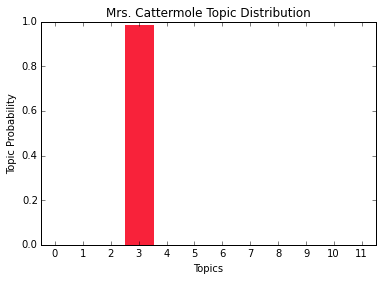

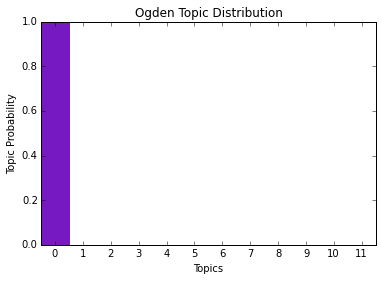

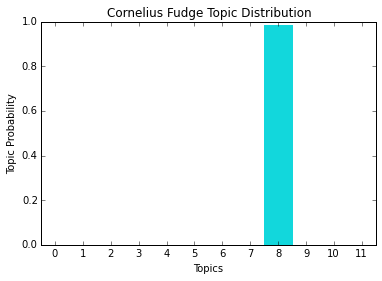

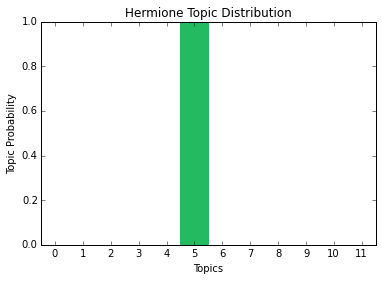

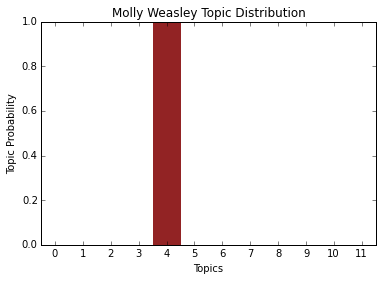

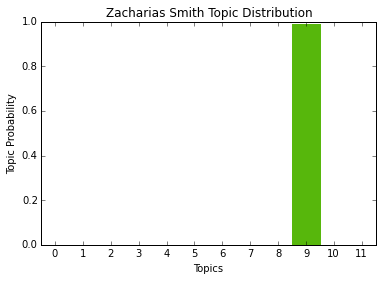

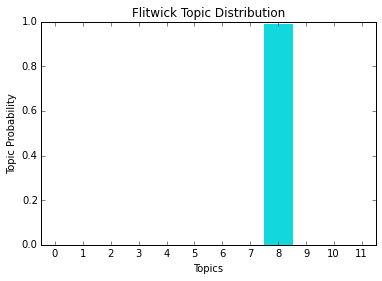

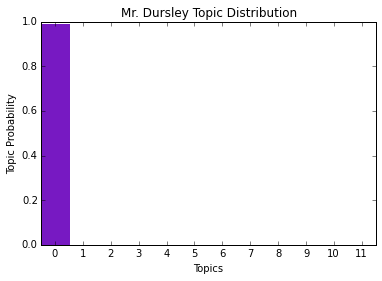

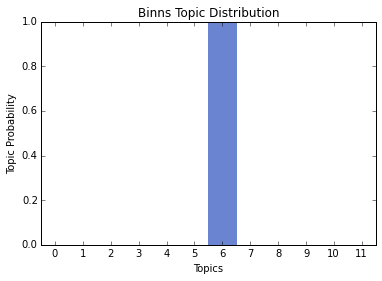

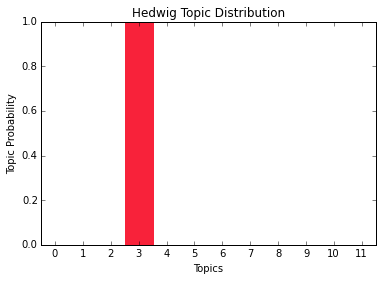

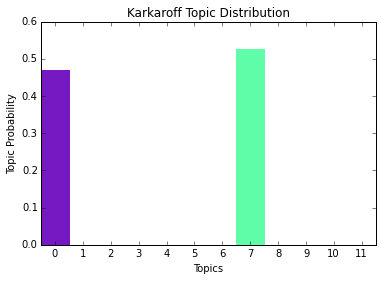

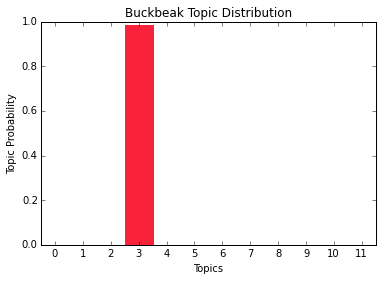

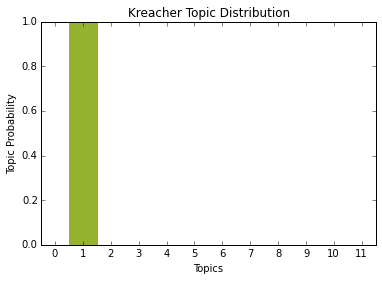

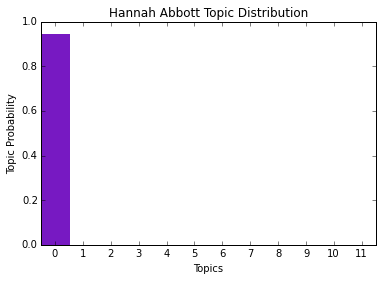

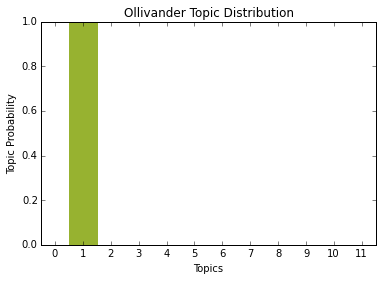

In [265]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

#### Use KMeans (is this the best choice?) and print out the clusters list

In [266]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[1, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 3, 1, 0, 3, 1, 3, 2, 2, 1, 1, 1, 1, 3, 1, 2, 0, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 0, 2, 3, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 3, 1, 1, 3, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1]
silhouette score: 0.411722602305
inertia: 58.2170265911


#### Print out characters and cluster assignments (in order)

In [267]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Montague', 0)
('Grubbly-Plank', 0)
('Bathilda', 0)
('Arthur', 0)
('Dean', 0)
('Mr. Crouch', 0)
('Katie', 0)
('Lee Jordan', 0)
('Ron', 0)
('Petunia Dursley', 0)
('Dursleys', 0)
('Mr. Weasley', 0)
('Vernon Dursley', 0)
('Wood', 0)
('Ginny', 0)
('Alicia', 0)
('Hermione', 0)
('Madam Rosmerta', 1)
('Dudley', 1)
('Cho', 1)
('Dolohov', 1)
('Nicolas Flamel', 1)
('Lavender Brown', 1)
('Fred', 1)
('Rufus Scrimgeour', 1)
('James', 1)
('Voldemort', 1)
('Crookshanks', 1)
('Bellatrix', 1)
('Maxime', 1)
('Yaxley', 1)
('Pettigrew', 1)
('Ministry of Magic', 1)
('Michael Corner', 1)
('George', 1)
('Fleur', 1)
('Greyback', 1)
('Goyle', 1)
('Godric', 1)
('Neville', 1)
('Johnson', 1)
('Norbert', 1)
('Gringotts', 1)
('Slughorn', 1)
('Griphook', 1)
('Borgin', 1)
('Mrs. Figg', 1)
('Parvati', 1)
('Phineas Nigellus', 1)
('Krum', 1)
('Rita Skeeter', 1)
('Nick', 1)
('Lily', 1)
('Mrs. Norris', 1)
('Hogwarts', 1)
('Marge', 1)
('Stan', 1)
('Gregorovitch', 1)
('Pansy Parkinson', 1)
('Justin', 1)
('Morfin', 1)
('Bar

#### Create data frame for clusters and characters

In [268]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [269]:
frame['clusters'].value_counts() 

1    69
3    27
2    22
0    17
Name: clusters, dtype: int64

#### Show visual cluster plot (all this code is heavily derivative of that guy's tutorial)

In [270]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [271]:
# TODO: change so that this automatically works with any of number clusters
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

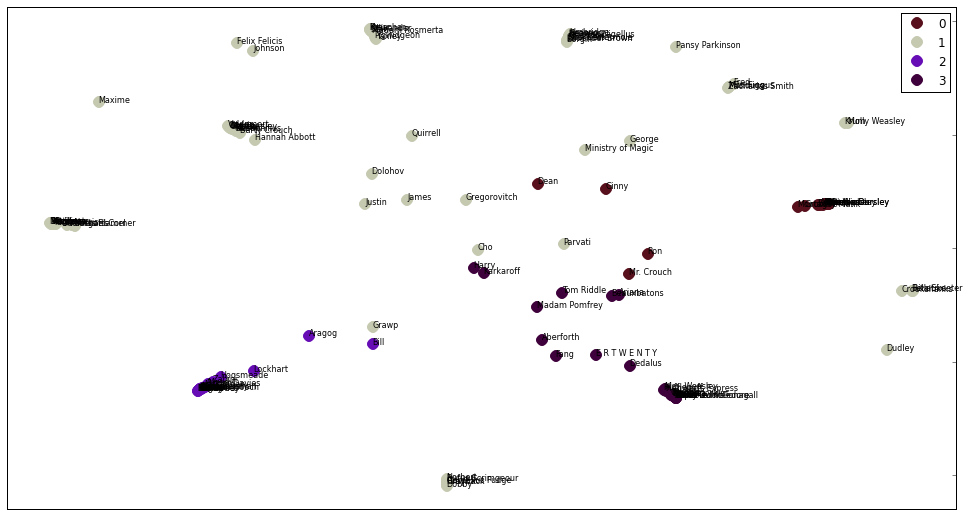

In [272]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [273]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters (again taken from the dude's tutorial)

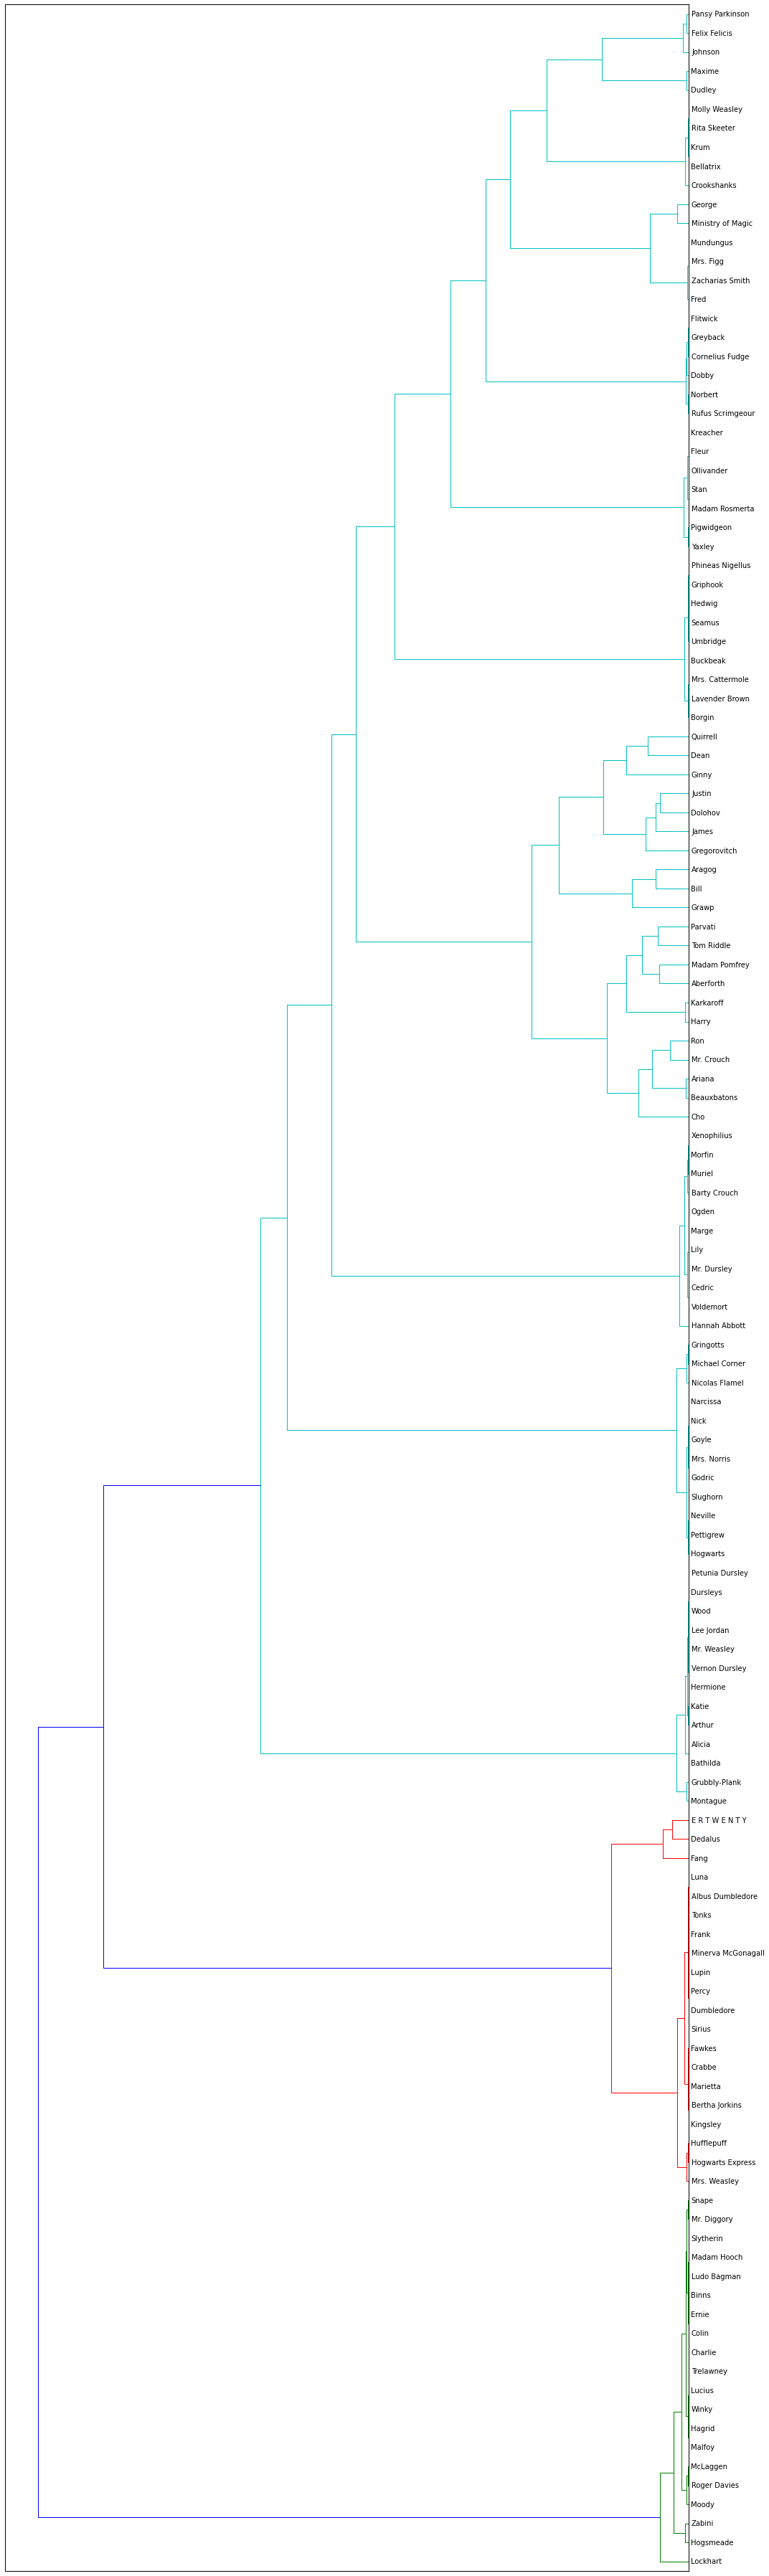

In [274]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [275]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [276]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [277]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

115


In [278]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

122 0
Madam Rosmerta
[0, 0, 1, 0]
[0, 0.98854137518149443, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

11 109
Ginny Weasley
[1, 0, 0, 0]
[0, 0, 0, 0.46127546472013192, 0, 0.53023445235419631, 0, 0, 0, 0, 0, 0]

116 86
Stan Shunpike
[0, 0, 1, 0]
[0, 0.99118570737369249, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 3
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.99903201559804145, 0, 0, 0, 0]

31 4
Dudley
[0, 1, 0, 0]
[0, 0, 0.99830869795125277, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 5
Cho
[1, 0, 0, 0]
[0.13937948024200361, 0, 0, 0, 0, 0.25643382296694867, 0, 0.28306464274345122, 0, 0, 0, 0.31775499409170377]

18 58
Arthur Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.98882094237333928, 0, 0, 0, 0, 0, 0]

84 119
Colin Creevey
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0.99229673801487883, 0, 0, 0, 0, 0]

65 8
Madam Hooch
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0.99003603408376062, 0, 0, 0, 0, 0]

91 51
Angelina Johnson
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.94607712179757419, 0]

125 9
Nicolas Flamel
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [279]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.74137931  0.70175439]
Precision:
[ 0.5         0.42857143]
Recall:
[ 0.26666667  0.4       ]

Antagonists
Accuracy:
[ 0.74137931  0.66666667]
Precision:
[ 0.33333333  0.30769231]
Recall:
[ 0.07142857  0.28571429]

Neutral
Accuracy:
[ 0.56896552  0.63157895]
Precision:
[ 0.47826087  0.57142857]
Recall:
[ 0.45833333  0.34782609]

Animals
Accuracy:
[ 0.77586207  0.84210526]
Precision:
[ 0.          0.16666667]
Recall:
[ 0.   0.2]

